In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd
from scipy.stats import cumfreq

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
GO_terms = ipy_utils.get_go_terms()
GO_terms.reverse()
all_tissues = ipy_utils.get_tissue_list('../data/tissues.txt')
results_dir = 'Results/median_results_1_tissue_loss_l2_neg_0'
aucs = ipy_utils.get_all_1_tissue_aucs(GO_terms, all_tissues, results_dir)

In [3]:
GO_to_GTEX = ipy_utils.map_GO_to_GTEX()
GTEX_to_GO = ipy_utils.map_GTEX_to_GO(GO_to_GTEX)

## Logistic Regression. L2 Penalty. Feature for a given tissue is the median.
Note that L1 penalty does not necessarily make sense here since an individual tissue's features need not be sparse.

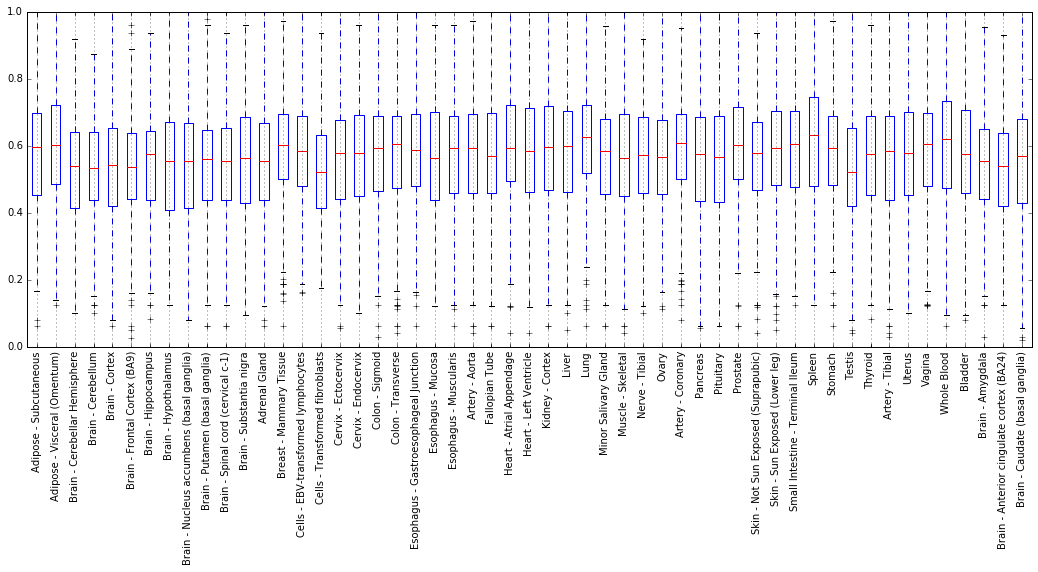

In [4]:
ipy_utils.make_boxplot(aucs, all_tissues)

In [5]:
def get_emp_cdf(arr, num_bins=53):
    # Get the empirical CDF of |arr|
    cumfreqs, _, _, _ = cumfreq(arr, num_bins, defaultreallimits=(0,num_bins+0.1))
    return (1.0 / arr.shape[1]) * cumfreqs  # Normalize the frequencies so that the max is 1

In [6]:
def plot_emp_cdf(auc_array, tissues, GO_terms, tissue_heats, colorbar_label, hmap_normalization=1,
                special_tissues=[], special_tissue_color='green',
                tissue_specific_GO=False, gtex_to_go_map=None):
    
    if tissue_specific_GO:
        # For each tissue, only consider its AUC ranking for associated GO terms
        assoc_rows = []  # rows of GO terms associated w/each tissue
        for i, tissue in enumerate(tissues):
            cur_assoc_rows = []  # rows of GO terms associated w/this tissue
            for term in gtex_to_go_map[tissue]:
                cur_assoc_rows.append(GO_terms.index(term))
            assoc_rows.append(sorted(cur_assoc_rows))
    
    # Generate the heatmap using the |tissue_heats| parameter
    cmap = plt.cm.YlOrRd
    min_val = min(tissue_heats)
    max_val = max(tissue_heats) / (1.0 * hmap_normalization)
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))

    num_tissues = len(tissues)
    num_GO_terms = auc_array.shape[0]

    plt.figure(figsize=(18, 6))
    ax = plt.gca()
    plt.ylim([0,1])
    plt.xlim([1, num_tissues])
    
    for i, tissue in enumerate(tissues):
        
        if tissue_specific_GO:
            cur_assoc_rows = assoc_rows[i]  # Row indexes of GO terms associated with this tissue
            if len(cur_assoc_rows) == 0:
                continue
                tissue_rankings = np.zeros(shape=(1,len(assoc_rows)))
            tissue_rankings = np.zeros(shape=(1,len(cur_assoc_rows)))
        else:
            tissue_rankings = np.zeros(shape=(1,num_GO_terms))
        
        idx = 0
        for j, row in enumerate(auc_array): # for each GO term
            if tissue_specific_GO and j not in cur_assoc_rows:
                continue
            cur_auc = row[i]  # ith tissue's AUC score for this GO term
            cur_ranking = 1 + sum(a > cur_auc for a in row)
            tissue_rankings[0,idx] = cur_ranking
            idx += 1
    
        emp_cdf = get_emp_cdf(tissue_rankings, num_bins=num_tissues)
        if tissue in special_tissues:
            colorVal = 'green'
        else:
            colorVal = scalarMap.to_rgba(tissue_heats[i]) 
        ax.plot(range(1,num_tissues+1), emp_cdf, color=colorVal)

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label(colorbar_label)    

    ax.set_xlabel('# of Tissues')
    ax.set_ylabel('% of GO Terms')
    ax.grid()
    plt.show()
    
    if len(special_tissues) > 0:
        print 'Highlighted tissues: ', ', '.join(special_tissues)

In [7]:
# Get # of GO terms and samples for each tissue. Use these counts for heatmaps
GO_counts = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
sample_counts = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]

special_tissues = []
thresh = 60  # number of GO terms for a tissue to be "special"
for i, tissue in enumerate(all_tissues):
    if len(GTEX_to_GO[tissue]) > thresh:
        special_tissues.append(tissue)

## Empirical "CDF" For L2 Norm, Single Tissue Features (Median feature)

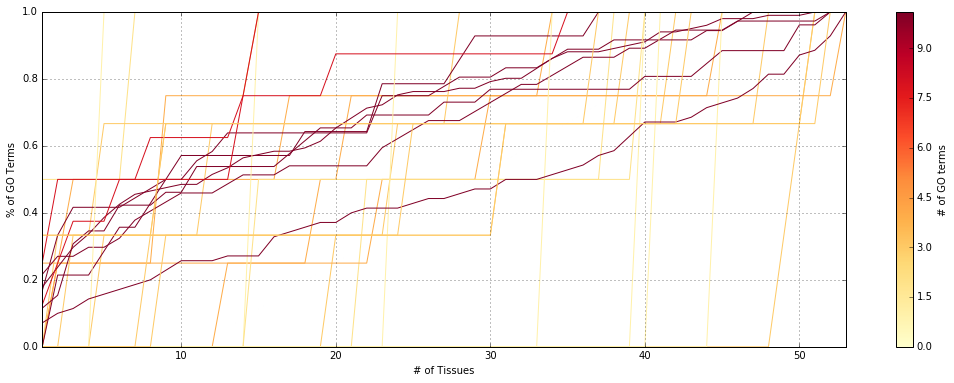

In [9]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

## Same as Above, But Heatmap by # of Samples Of this Tissue.

Suggests that when there are more samples, the median feature is not necessarily more reliable.

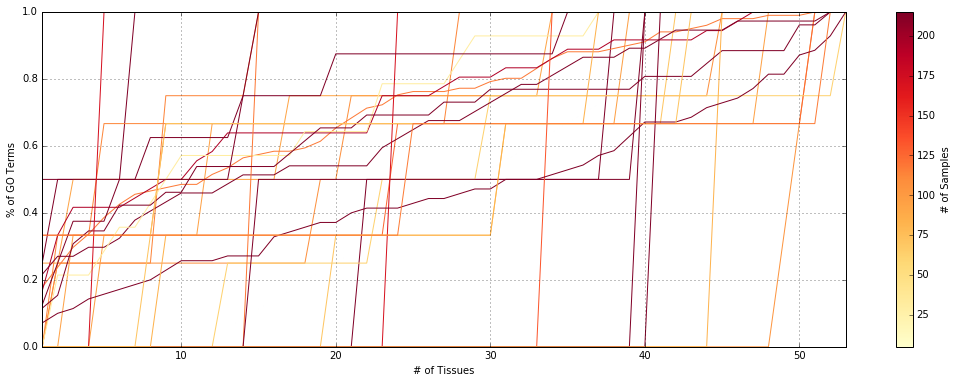

In [10]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

## CDF Curves For ALL GO Terms (Not just those associated w/the Tissue)

Notice the high values at the bottom left for tissues with many GO terms. However, this high value then tapers off. May suggest that some GO terms are just not very tissue specific.

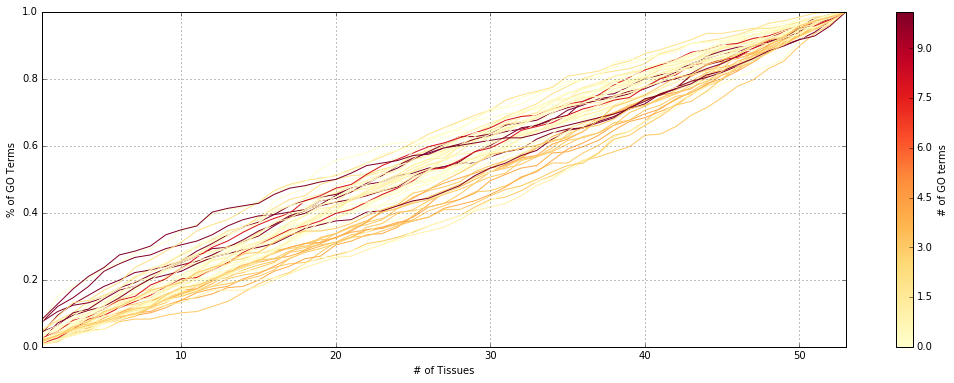

In [12]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10)

## Same as Above but colored by # of samples of each tissue.

As in the case of PCA, notice that the tissues with many samples no longer dominate. 

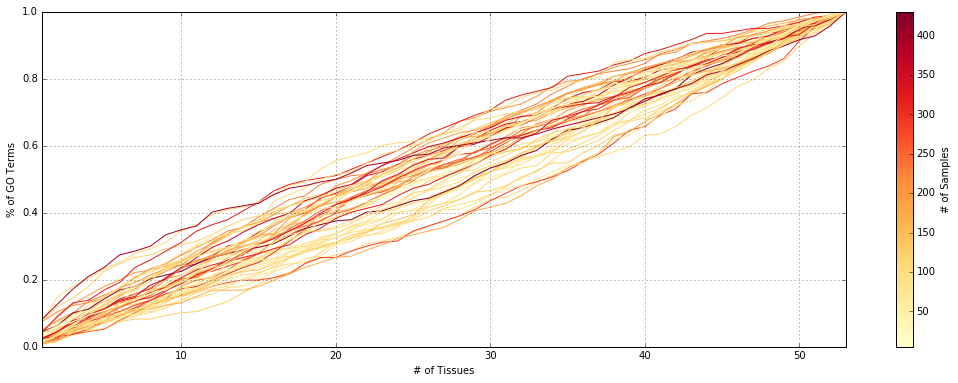

In [13]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1)